In [ ]:
%%Capture
#!pip install -q timm

In [1]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    # si usas facebook/deit-base-patch16-384 debes cambiar: result[0, 0 , 2 :]
    # if you use facebook/deit-base-patch16-384 you must change: result[0, 0 , 2 :]
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask 
    
class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

Using cuda


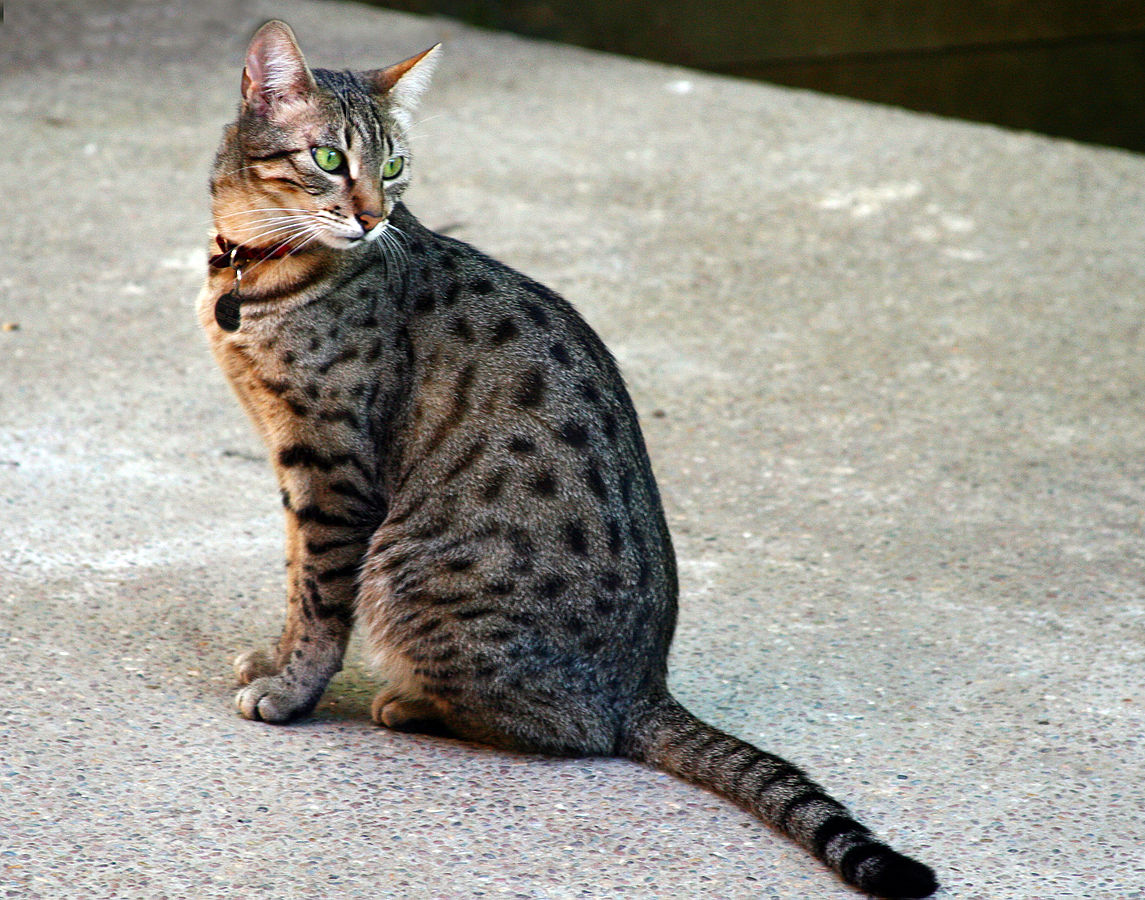

In [4]:
import requests
URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7f/Egyptian_Mau_Bronze.jpg/1145px-Egyptian_Mau_Bronze.jpg"
response = requests.get(URL)
open("image.jpg", "wb").write(response.content)
img = Image.open('./image.jpg')
img

In [5]:
model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)
IMAGE_SIZE = 224
DISCARD_RATIO = 0.9
attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)
image  = preprocess_image("image.jpg", transform)
mask = attention_rollout(image)
image.shape

Using cache found in C:\Users\Sandro_Alex/.cache\torch\hub\facebookresearch_deit_main


torch.Size([1, 3, 224, 224])

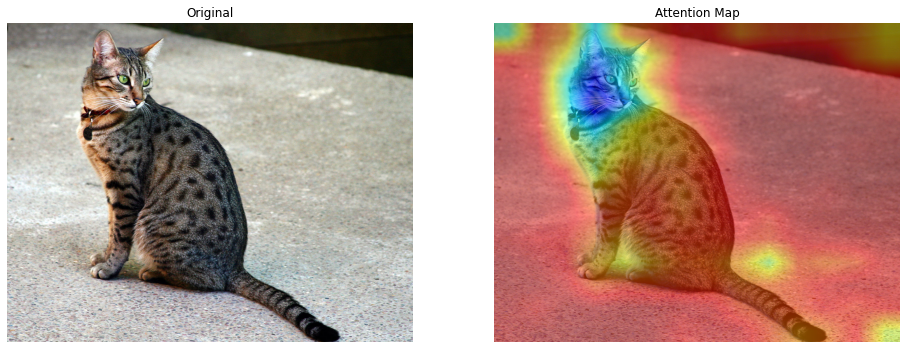

In [6]:

np_img = np.array(img)[:, :, ::-1]

mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask.shape, np_img.shape
mask = show_mask_on_image(np_img, mask)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax1.axis('off')
_ = ax2.imshow(mask)
_ = ax2.axis('off')
#print(input_tensor.shape)